In [51]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from CoolProp.CoolProp import PropsSI
from pint import UnitRegistry
u = UnitRegistry()
u.default_format = 'C'
import math as m


# Options for pandas a
#pd.options.display.max_columns = 50
#pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()
from IPython.display import display_latex

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
h = 8
w = h*1.61803398875
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

#from matplotlib import rc
plt.rc('font',**{'family':'serif','serif':['Times New Roman']})
plt.rc('text', usetex=True)

# Publish
from ipypublish.scripts import nb_setup

# Introduction
A fire and subsequent explosion occurred at approximately 4:22am on June 21, 2019, at the Philadelphia Energy Solutions Girard Point Refinery, see \cref{fig:fire} \cite{Renshaw2019}.  The explosion took place in the V1 treater-feed-surge-drum (TFSD) within the pretreatment unit.  The TFSD explosion propelled a $41809.6lb\:(18964.5kg)$ piece of the steel drum approximately $2100ft\:(640m)$ from the blast seat, see \cref{fig:tank}.  It is hypothesized that a boiling-liquid expanding-vapor explosion (BLEVE) event generated the blast wave and broke the drum into fragments.  The Philadelphia Fire Department requested ATF estimate the blast overpressure, debris throw, and thermal effects generated when the tank exploded.  This paper will estimate these blast parameters assuming a BLEVE occurred.  The analysis is based upon an adiabatic and isentropic energy analysis developed by the Center for Chemical Process Safety \cite{Safety2010}.  Analysis was completed using Jupyter Notebook running Python 3.7 and published using ipypublish\cite{Sewell2019}\cite{Kluyver2019}. 

![A view of the Philadelphia Energy Solutions Incs oil refinery on fire June 21, 2019 \cite{Maykuth2019}.](report_images/fig_refinery_fire.png){#fig:fire width=100% placement='H'}

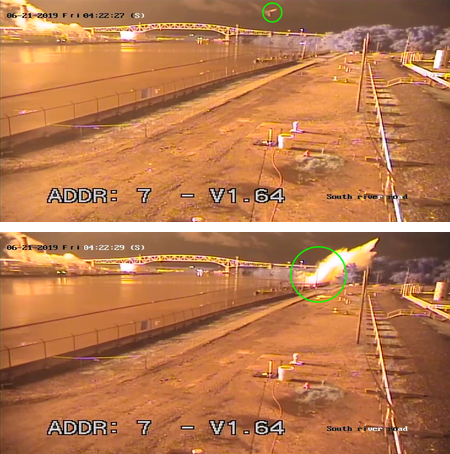

In [53]:
image1 = 'report_images/drum_in_flight.png'
image2 = 'report_images/drum_landing.png'
nb_setup.images_vconcat([image1, image2], width=450, gap=10)


# Background

## Refinery

The Girard Point Refinery is the largest refinery on the East Coast, located in southwest Philadelphia, PA, on the Schuylkill River, see \cref{fig:map}.  Prior to the fire and explosion, the refinery produced approximately 335,000 barrels of gasoline per day \cite{AssociatedPress2019}.   

![Map of Girard Point Refinery showing the blast seat location \cite{Duchneskie2019}.](report_images/fig_map_girard.jpeg){#fig:map width=100% placement='H'}

## Treater Feed Surge Drum

The TFSD, located between the fluid catalytic cracker and the alkylation unit, was part of the alkylation pretreatment process, see \cref{fig:fig_pf}. The purpose of a surge drum is to stabilize fluctuations in the overall system flow rate. During pretreatment, also referred to as sweetening, sulfur compounds (hydrogen sulfide, thiophene and mercaptan) are removed to improve color, odor, and oxidation stability.  Following pretreatment, alkylation generally converts propylene $(C_3H_6)$, butylene $(C_4H_8)$, pentene $(C_5H_{10})$, and isobutane $(C_3H_{10})$ to alkane liquids such as isoheptane $(C_7H_{16})$ and isooctane $(C_8H_{16})$.  Because of their high octane and low vapor pressure, these alkylates are a highly valued component in the production of gasoline  \cite{flowserve2000}.   

![Simple flow diagram showing the TFSD in the alkylation pretreatment process\cite{Temur2014,Malone2019}.](report_images/fig_process_flow.png){#fig:fig_pf width=100% placement='H'}

The TFSD tank measured $39.66ft\:(12.09m)$ in length, not including the heads, see \cref{tbl:tbl_tank} and \cref{fig:fig_tank} for construction details \cite{PES2019}. At the time of the explosion, the TFSD contained $20160gal\:(76.3m^3)$ of butane (50% by volume) and butene (40% by volume) and other lesser constituients, see \cref{tbl:tbl_chemicals_in_tank} for a complete list of chemicals present.

Parameter             Value              Units
--------              --------           --------
Type                  horizontal         NA
Year Built            1972               NA
Construction Material A516 Type 70 Steel NA
Tank Wall Thickness   0.8125             in
Volume                37201              gal
Percent Filled        53.3               %
Mass                  74660              lb
Safety Valve Set      155                psig

Table: Treater-Feed-Surge-Drum Construction Parameters \cite{PES2019} {#tbl:tbl_tank align=rll widths=[0.25,0.25,0.25]}

![Diagram depicting the dimensions of the TFSD tank.  The tank was positioned $25ft\:(7.6m)$ above ground level and estimated to contain $20160gal\:(76.3m^3)$ (53.3% filled) of butane (50% by volume) and butene (40% by volume) at the time of the explosion.\cite{PES2019}](report_images/fig_tank.png){#fig:fig_tank width=100% placement='H'}

Chemical  Percent by Volume
--------  --------
methane     0.01
ethylene    0.00
ethane      0.01
propane     0.90
propylene   0.10
isobutane  37.28
nbutane    12.81
butens     40.41
neopentane  0.00
isopentane  3.94
npentane    0.25
butadiene   0.33
benzene     0.00
C5 olefins  3.54
C6 sats     0.33
C7+         0.04

Table: Chemical Contents in the Treater-Feed-Surge-Drum at the Time of the Explosion \cite{PES2019} {#tbl:tbl_chemicals_in_tank align=rr widths=[0.2,0.2]}

For this analysis, it will be assumed the entire mixture is butane.  This assumption avoids partial pressures and multiple energy calculations with different vapor qualities greatly simplifying the analysis.  The assumption is reasonable because butane and butene are chemically similar and make up more than 90% of the fluid volume, see \cref{tbl:tbl_butane_prop}.   A BLEVE assumption is reasonable because, the boiling temperatures for butene $\left(20.66\: ^{\circ} F\:(-6.3\: ^{\circ} C)\right)$ and butane $\left(31.1\: ^{\circ} F\:(-1.0\: ^{\circ} C)\right)$ are both well above the tank temperature when exposed to fire. 


| Property                  | Butene      | Butane     |
|---------------------------|-------------|------------|
| Molecular Formula         | $C_4H_8$        | $C_4H_{10}$      |
| Molecular Weight          | $56.108\frac{g}{mol}$ | $58.12g\frac{g}{mol}$ |
| Boiling Point at 760mm Hg | $20.6^{\circ}F$ | $31.1^{\circ}F$     |
| Flash Point               | $-110.0^{\circ}F$ | $-76.0^{\circ}F$      |
| Density at 25$^{\circ} C$, 1 atm    | $0.588\frac{g}{cc}$  | $0.573\frac{g}{cc}$ |
| $\frac{C_P}{C_V}$ Ratio $\gamma$  |1.13    | 1.12                 |

Table: Chemical Properties of Butene and Butane \cite{PubChem-butane, PubChem-butene} {#tbl:tbl_butane_prop align=rrr widths=[0.3,0.3,0.3]}

## Pressure Relief Valve

The TFSD was fitted with a Consolidated (1906-30LC-1-CC-MS-31-RF-1) $3in\:x\:4in\:(7.63cm\:x\:10.16cm)$ pressure relief valve (PRV).  The relief pressure was set to $155 psig\:(1068.7kPa)$ and the relief temperature was set to $183.5^{\circ} F\:(84.3^{\circ}C)$.  The PRV was positioned on the top of the TFSD, see \cref{fig:fig_tank}.  It is assumed the PRV functioned as designed.

## Recovered Drum Debris
Three major pieces of the TFSD were identified after the explosion, see \cref{fig:blast_debris}.  The largest piece (large-end-cap) was recovered $2100ft\:(640m)$ from the blast seat.  It was approximately $22ft\:(6.7m)$ in length, or a little more than half the original tank length, see \cref{fig:large_end_cap}.  The other end of the TFSD (small-end-cap) was recovered $1761ft\:(536m)$ from the blast seat.  It was approximately $5ft\:(1.5m)$ in length, see \cref{fig:small_end_cap}.  The piece thrown the shortest distance (center-section) was $819ft\:(249m)$ from the blast seat.  The center-section piece was heavily damaged and a photographic analysis of the length was not possible.  However, based on the original length of the tank after removing the large and small-end-cap lengths, the center-section length is approximately $12ft\:(3.6m)$, see \cref{fig:fillet}.

![Map of Girard Point showing the blast seat and locations of the three main pieces of the TSFD (V-1) recovered.\cite{Malone2019a}](report_images/drum_debris_and_blast_seat_distances.jpg){#fig:blast_debris width=100% placement='H'}

![Photograph of the large-end-cap, estimated to be $22ft\:(6.7m)$ in length based on photographic analysis.  In this photograph the tank has been moved from it's original landing location.\cite{Malone2019a}](report_images/tank_length_estimate.png){#fig:large_end_cap width=100% placement='H'}

![Photograph of the small-end-cap, estimated to be $5ft\:(1.5m)$ in length based on photographic analysis.\cite{Malone2019a}](report_images/end_cap_03.jpg){#fig:small_end_cap width=100% placement='H'}

![Photograph of the center-section piece, calculated to be $12ft\:(3.6m)$ in length based on the total length of the drum less the lengths of the large and small-end-caps.\cite{Malone2019a}](report_images/1_fish_fillet2.jpg){#fig:fillet width=100% placement='H'}

The estimated mass of each piece of the TFSD is summarized in \cref{tbl:tbl_tank_wt}.  The mass calculations are based on the refinery recorded mass of the vessel, $74660lb\:(33865kg)$, multiplied by the percent mass calculated using the following equations,

Ellipsoidal Head: $$V_{eh}=\frac{\pi D^2 (D/4)}{6}$$
Cylinder: $$V_c = \frac{\pi D^2 l}{4}$$

where the drum wall thickness is $0.83in\:(2.1cm)$, the tank diameter is $12ft\:(3.7m)$, and the material density for A516 steel is $7.8g/cc$\cite{Malone2019}.  The difference in calculated and refinery recorded mass is likely due to other structural components attached to the tank not accounted for in the calculated mass.

TFSD ID               Cylinder (ft)      Calculated Debris Mass (lb)   Percent Mass Calculated         Refinery Recorded Mass (lb)  
--------              -------------      --------------------          -----------------------------   ---------------------
Large-End-Cap         22.0               31541.8                       0.56                            41809.6
Small-End-Cap          5.0               10078.5                       0.18                            13438.8
Center-Section        12.0               15150.5                       0.26                            19411.6
Total                 39.0               56770.8                       1.00                            74660.0

Table: Estimated TFSD Debris Mass \cite{PES2019} {#tbl:tbl_tank_wt align=lrrrr widths=[0.2,0.1,0.1,0.15,0.15]}


## Boiling-Liquid Expanding-Vapor Explosion (BLEVE)

A BLEVE results from the sudden failure of a tank containing a compressed vapor (head space) and a super-heated liquid (a liquid heated above it's boiling point but without boiling). The magnitude of the blast depends on how super-heated the liquid was at failure.  There is a direct relationship between the super-heat temperature and the quantity of liquid that flash-boils.  Higher volumes of fluid that flash-boil release more energy.  Once containment failure occurs, the energy is distributed into four forms:

1. Overpressure wave
2. Kinetic energy of fragments
3. Deformation and failure of the containment material
4. Heat transferred to environment

The distribution of the energy into the these four forms depends on the specifics of the explosion.  Planas-Cuchi et al. found that a *brittle*\footnote{Brittle failure refers to the breakage of a material due to a sudden fracture. When a brittle failure occurs, the material breaks suddenly instead of deforming or straining under load. The fracturing or breaking can occur with only a small amount of load, impact force or shock. Brittle materials absorb less energy before breaking or fracturing, despite the materials having a high strength.} failure releases 80% of the energy into the blastwave, while a *ductile*\footnote{A ductile failure is a type of failure seen in malleable materials characterized by extensive plastic deformation or necking. This usually occurs prior to the actual failure of the material. The term ductile rupture refers to the failure of highly ductile materials. In such cases, materials pull apart instead of cracking.} failure releases 40% of the energy into the blastwave.  The remaining energy becomes kinetic energy of the fragments.  The heat transfer to the environment is relatively small \cite{Planas2004}.  In practice, most pressure vessels are designed with materials that are ductile rather than brittle to avoid sudden and catastrophic brittle (fragile) failures \cite{Benac2016}.

In [54]:
# Large End Cap Weight
dia = 12 * u.feet
thk = 0.06916667 * u.feet
lng = 22 * u.feet
den = 487 * u.lb/u.ft**3

hv = ellipsoidal_head(dia, thk)
cv = cylinder(lng, dia, thk)

wt_h = hv*den
wt_c = cv*den
wt_t = wt_c + wt_h
round(wt_t,3)
l_over_d = lng/dia

31541.808 <Unit('pound')>

In [55]:
# Small End Cap Weight
dia = 12 * u.feet
thk = 0.06916667 * u.feet
lng = 5 * u.feet
den = 487 * u.lb/u.ft**3

hv = ellipsoidal_head(dia, thk)
cv = cylinder(lng, dia, thk)

wt_h = hv*den
wt_c = cv*den
wt_t = wt_c + wt_h
round(wt_t,3)

10078.562 <Unit('pound')>

In [56]:
# Fillet Weight
dia = 12 * u.feet
thk = 0.06916667 * u.feet
lng = 12 * u.feet
den = 487 * u.lb/u.ft**3

cv = cylinder(lng, dia, thk)

wt_c = cv*den

round(wt_c,3)

15150.527 <Unit('pound')>

In [57]:
p_relief = 155 * u.psi
p_relief = p_relief.to(u.Pa)
p_atm = 101325.0 * u.Pa
p_1 = 1.21*(p_relief + p_atm).to(u.Pa)
p_2  = p_atm; #
V_drum = 140.8197 * u.m**3
Pct_l = 0.533 # percent by volume of fluid in the tank
Pct_g = 1 - Pct_l # percent by volume of vapor in the tank
R = 10* u.m
a0 = 340 * u.m / u.s
vol_l = V_drum * Pct_l
vol_g = V_drum * Pct_g
gnd = 1.25
frag = 0.4
mass = 74660 * u.lb
mass_p = 2723 * u.kg
gamma = 1.12
gamma_p = 1.13
RGC = 8314.41 * (u.J)/(u.kmol * u.K)
T = 350 * u.K
mb = 58.12 * u.kg / u.kmol
mp = 44.00 * u.kg / u.kmol
den_p = 585.3 * u.kg/u.m**3 #@-46C
den_b = 604 * u.kg/u.m**3 #@25C

print('P_relief = {:P.2f} ({:P.2f})'.format(p_relief.to(u.psi), p_relief.to(u.kPa)))
print('P_atm = {:P.2f} ({:P.2f})'.format(p_atm.to(u.psi), p_atm.to(u.kPa)))
print('P_1 = {:P.2f} ({:P.2f})'.format(p_1.to(u.psi), p_1.to(u.kPa)))
print('P_2 = {:P.2f} ({:P.2f})'.format(p_2.to(u.psi), p_2.to(u.kPa)))
print('V_drum = {:P.2f} ({:P.2f})'.format(V_drum, V_drum.to(u.gal)))
print('% liquid = {:.2f}'.format(Pct_l))
print('% vapor = {:.2f}'.format(Pct_g))
print('R = {:P.2f} ({:P.2f})'.format(R.to(u.ft), R))
print('a0 = {:P.2f} ({:P.2f})'.format(a0.to(u.ft / u.s), a0))
print('V_l = {:P.2f} ({:P.2f})'.format(vol_l, vol_l.to(u.gal)))
print('V_g = {:P.2f} ({:P.2f})'.format(vol_g, vol_g.to(u.gal)))
print('mass_drum = {:P.2f} ({:P.2f})'.format(mass, mass.to(u.kg)))
print('T = {:P.2f} ({:P.2f})'.format(T.to(u.degF), T))
print('mol_wt_butane = {:P.2f} ({:P.2f})'.format(mb.to(u.lb / u.mol), mb))

P_relief = 155.00 pound_force_per_square_inch (1068.69 kilopascal)
P_atm = 14.70 pound_force_per_square_inch (101.33 kilopascal)
P_1 = 205.33 pound_force_per_square_inch (1415.71 kilopascal)
P_2 = 14.70 pound_force_per_square_inch (101.33 kilopascal)
V_drum = 140.82 meter ** 3 (37200.63 gallon)
% liquid = 0.53
% vapor = 0.47
R = 32.81 foot (10.00 meter)
a0 = 1115.49 foot / second (340.00 meter / second)
V_l = 75.06 meter ** 3 (19827.94 gallon)
V_g = 65.76 meter ** 3 (17372.69 gallon)
mass_drum = 74660.00 pound (33865.21 kilogram)
T = 170.33 degF (350.00 kelvin)
mol_wt_butane = 0.13 pound / mole (58.12 kilogram / kilomole)


# Overpressure and Impulse from the BLEVE
There is a seven step method for calculating the overpressure and impulse from a BLEVE.  The method is given in \cref{fig:fig_bleve_process}.

![Calculation of energy of flashing liquids and pressure vessel bursts filled with vapor or nonideal gas. \cite{Safety2010}](report_images/fig_bleve_airblast_calc.png){#fig:fig_bleve_process width=35% placement='H'}

## Data Collection
For this analysis the following data will be used:

1.  Ambient air pressure, $14.7psi\:(101.3kPa)$
2.  Vessel volume, $37200.63gal\:(140.82m^3)$
3.  Ratio of specific heats of butane (1.12)
4.  Distance from the center of the tank to the receptor, $32.81ft\:(10.00m)$
5.  Shape of the vessel is cylindrical, $L/D=3.29$
6.  Speed of sound of air, $1115.49ft/s\:(340.00m/s)$

## Internal Energy

### Pressure at State 1 (Pre-failure State)
The TFSD is assumed to fail at $1.21$ times the opening pressure of the pressure relief valve (PRV)\cite{Engineers2013}.  This pressure is based on the American Petroleum Institutes Standard 521 requiring pressure relief valves on pressure vessels to achieve rated flow at 1.21 times the maximum allowable working pressure.  The PRV was set to $155.00psi\:(1068.69kPa)$ therefore, the absolute pressure at state 1 (failure state) is given by,

$$p_1 = 1.21\left(p_{PRV}+p_{atm}\right)$$
$$p_1 = 1.21\left(155.00+14.70\right)$$
$$p_1 = 205.33 psia\:(1.42\:MPa)$$

### Pressure at State 2 (Final Expanded State)
The pressure at state 2 (final expanded state) is standard atmospheric pressure or $14.7psi\:(101.3kPa)$.

### Internal Energy
The internal energy $u$ can be used to estimate the energy released in an explosion.  With the gases in the saturated state and knowing the pressures at state 1 (explosion) and state 2 (atmospheric), lookup tables can be used to determine the specific volume $v$, and the enthalpy $h$.  Combining these two properties with the pressure, the internal energy $u$ can be calculated using,

$$h = u + pv$$

where $h$ is the enthalpy, $p$ is the pressure, and $v$ is the specific volume.  Therefore, solving for the internal energy $u$ we have,

$$u = h - pv$$

#### Internal Energy at State 1
The internal energy at state 1 for saturated liquid butane is,

$$u_{1f} = h_{1f} - (p_{1})(v_{1f})$$
$$u_{1f} = 451.46\:kJ/kg - (1415.72\:kPa)(0.002110\:m^3/kg)$$
$$u_{1f} = 448.47\:kJ/kg$$

and for the saturated vapor butane at state 1 we have,

$$u_{1g} = h_{1g} - (p_{1})(v_{1g})$$
$$u_{1g} = 716.93\:kJ/kg - (1415.72\:kPa)(0.027658\:m^3/kg)$$
$$u_{1g} = 677.77\:kJ/kg$$

and similarly for saturated liquid and vapor butane at state 2,

$$u_{2f} = 198.70\:kJ/kg$$
$$u_{2g} = 547.18\:kJ/kg$$

All the gas properties are summarized in \cref{tbl:thermo}

In [58]:
#propane calculations for comparision example problem *** DELETE ***
p_relief_p = 15 * u.bar
p_relief_p = p_relief_p.to(u.Pa)
p_p = 1.21*(p_relief_p + p_atm).to(u.Pa)
R_p = 100 * u.m
propane_1 = chem_prop(p_p.magnitude,'Propane','1')
propane_2 = chem_prop(p_2.magnitude,'Propane','2')
propane_dict = build_state_table(propane_1,propane_2)
V_1 = 25 * u.m**3
# Philadelphia Refinery Calculations
# Butane
butane_1 = chem_prop(p_1.magnitude,'butane','1')
butane_2 = chem_prop(p_2.magnitude,'butane','2')
butane_dict = build_state_table(butane_1,butane_2)

# Combine all calculations into a Pandas Dataframe
pd = nb_setup.setup_pandas(escape_latex=False)
df1 = pd.DataFrame(butane_dict)
df2 = pd.DataFrame(propane_dict)
df = pd.concat([df1, df2])
df.set_index('State', inplace=True)
pd.options.display.float_format = '{:.2E}'.format
df[0:2]

,$P \left(kPa\right)$,$u_f \left(\frac{kJ}{kg\:K}\right)$,$u_g \left(\frac{kJ}{kg\:K}\right)$,$v_f \left(\frac{m^3}{kg}\right)$,$v_g \left(\frac{m^3}{kg}\right)$,$s_f \left(\frac{kJ}{kg\:K}\right)$,$s_g \left(\frac{kJ}{kg\:K}\right)$,$h_f \left(\frac{kJ}{kg}\right)$,$h_g \left(\frac{kJ}{kg}\right)$
State,,,,,,,,,
butane-1,1.42E+03,4.48E+02,6.78E+02,2.11E-03,2.77E-02,1.78E+00,2.49E+00,4.51E+02,7.17E+02
butane-2,1.01E+02,1.99E+02,5.47E+02,1.66E-03,3.69E-01,9.96E-01,2.41E+00,1.99E+02,5.85E+02


In [59]:
print_ie('1','butane',0)
print_ie('2','butane',1)
print_ie('1','propane',2)
print_ie('2','propane',3)

Internal energy of liquid butane at state 1:   448.47 =   451.46 - ( 1415.71)(0.002110)
Internal energy of gaseous butane at state 1:   677.77 =   716.93 - ( 1415.71)(0.027658)
Internal energy of liquid butane at state 2:   198.70 =   198.87 - (  101.33)(0.001663)
Internal energy of gaseous butane at state 2:   547.18 =   584.58 - (  101.33)(0.369098)
Internal energy of liquid propane at state 1:   350.15 =   354.58 - ( 1937.60)(0.002287)
Internal energy of gaseous propane at state 1:   581.68 =   625.20 - ( 1937.60)(0.022459)
Internal energy of liquid propane at state 2:   100.18 =   100.36 - (  101.33)(0.001722)
Internal energy of gaseous propane at state 2:   484.01 =   525.95 - (  101.33)(0.413884)


In [60]:
v_f1p = propane_1[6] * u.m**3 / u.kg
v_g1p = propane_1[5] * u.m**3 / u.kg
print('Propane')
print('v_f1p = {:P.4f}'.format(v_f1p))
print('v_g1p = {:P.4f}'.format(v_g1p))
v_f1b = butane_1[6] * u.m**3 / u.kg
v_g1b = butane_1[5] * u.m**3 / u.kg
print('Butane')
print('v_f1b = {:P.4f}'.format(v_f1b))
print('v_g1b = {:P.4f}'.format(v_g1b))

Propane
v_f1p = 0.0023 meter ** 3 / kilogram
v_g1p = 0.0225 meter ** 3 / kilogram
Butane
v_f1b = 0.0021 meter ** 3 / kilogram
v_g1b = 0.0277 meter ** 3 / kilogram


In [61]:
Xf2p, Xg2p = quality(propane_1, propane_2)
Xf2b, Xg2b = quality(butane_1, butane_2)
print('Propane')
print('X_f2p = %1.3f' % Xf2p)
print('X_g2p = %1.3f' % Xg2p)
print('Butane')
print('X_f2b = %1.3f' % Xf2b)
print('X_g2b = %1.3f' % Xg2b)

Propane
X_f2p = 0.486
X_g2p = 0.067
Butane
X_f2b = 0.552
X_g2b = 0.060


In [62]:
s_f1b = butane_1[4] * u.kJ / (u.kg * u.K)
s_f2b = butane_2[4] * u.kJ / (u.kg * u.K)
s_g1b = butane_1[3] * u.kJ / (u.kg * u.K)
s_g2b = butane_2[3] * u.kJ / (u.kg * u.K)

s_f1p = propane_1[4] * u.kJ / (u.kg * u.K)
s_f2p = propane_2[4] * u.kJ / (u.kg * u.K)
s_g1p = propane_1[3] * u.kJ / (u.kg * u.K)
s_g2p = propane_2[3] * u.kJ / (u.kg * u.K)
print('Butane')
print('s_f1b = {:P.4f}'.format(s_f1b))
print('s_f2b = {:P.4f}'.format(s_f2b))
print('s_g1b = {:P.4f}'.format(s_g1b))
print('s_g2b = {:P.4f}'.format(s_g2b))
print('Propane')
print('s_f1p = {:P.4f}'.format(s_f1p))
print('s_f2p = {:P.4f}'.format(s_f2p))
print('s_g1p = {:P.4f}'.format(s_g1p))
print('s_g2p = {:P.4f}'.format(s_g2p))

Butane
s_f1b = 1.7760 kilojoule / kelvin / kilogram
s_f2b = 0.9959 kilojoule / kelvin / kilogram
s_g1b = 2.4948 kilojoule / kelvin / kilogram
s_g2b = 2.4105 kilojoule / kelvin / kilogram
Propane
s_f1p = 1.5032 kilojoule / kelvin / kilogram
s_f2p = 0.6070 kilojoule / kelvin / kilogram
s_g1p = 2.3260 kilojoule / kelvin / kilogram
s_g2p = 2.4491 kilojoule / kelvin / kilogram


In [63]:
u_f2b = butane_2[10] * u.kJ / u.kg
u_g2b = butane_2[9] * u.kJ / u.kg
print('Saturated Butane at State 2')
print('u_f2b = {:P.4f}'.format(u_f2b))
print('u_g2b = {:P.4f}'.format(u_g2b))

u_f2xb = (1-Xf2b)*u_f2b + (Xf2b)*(u_g2b)
u_g2xb = (1-Xg2b)*u_g2b + (Xg2b)*(u_f2b)
print('Unsaturated Butane at State 2')
print('u_f2xb = {:P.4f}'.format(u_f2xb))
print('u_g2xb = {:P.4f}'.format(u_g2xb))


Saturated Butane at State 2
u_f2b = 198.6973 kilojoule / kilogram
u_g2b = 547.1762 kilojoule / kilogram
Unsaturated Butane at State 2
u_f2xb = 390.8905 kilojoule / kilogram
u_g2xb = 526.3984 kilojoule / kilogram


In [64]:
u_f2p = propane_2[10] * u.kJ / u.kg
u_g2p = propane_2[9] * u.kJ / u.kg
print('Saturated Propane at State 2')
print('u_f2p = {:P.4f}'.format(u_f2p))
print('u_g2p = {:P.4f}'.format(u_g2p))

u_f2xp = (1-Xf2p)*u_f2p + (Xf2p)*(u_g2p)
u_g2xp = (1-Xg2p)*u_g2p + (Xg2p)*(u_f2p)
print('Unsaturated Propane at State 2')
print('u_f2xp = {:P.4f}'.format(u_f2xp))
print('u_g2xp = {:P.4f}'.format(u_g2xp))

Saturated Propane at State 2
u_f2p = 100.1819 kilojoule / kilogram
u_g2p = 484.0111 kilojoule / kilogram
Unsaturated Propane at State 2
u_f2xp = 286.9068 kilojoule / kilogram
u_g2xp = 458.3459 kilojoule / kilogram


In [65]:
u_f1p = propane_1[10] * u.kJ / u.kg
u_exfp = u_f1p - u_f2xp
print('u_exfp = {:P.3f}'.format(u_exfp))

u_exfp = 63.246 kilojoule / kilogram


In [66]:
u_g1p = propane_1[9] * u.kJ / u.kg
u_exgp = u_g1p - u_g2xp
print('u_exgp = {:P.3f}'.format(u_exgp))

u_exgp = 123.336 kilojoule / kilogram


In [67]:
u_f1b = butane_1[10] * u.kJ / u.kg
u_exfb = u_f1b - u_f2xb
print('u_exfb = {:P.3f}'.format(u_exfb))

u_exfb = 57.578 kilojoule / kilogram


In [68]:
u_g1b = butane_1[9] * u.kJ / u.kg
u_exgb = u_g1b - u_g2xb
print('u_exgb = {:P.3f}'.format(u_exgb))

u_exgb = 151.375 kilojoule / kilogram


#### Internal Energy at State 2
When the drum containment fails and the butane at state 1 expands to state 2 (atmospheric pressure), it is no longer at a saturated stated.  Some of the liquid vaporizes and some of the vapor condenses. The quality of the vapor and liquid can be used to calculate the unsaturated internal energy at state 2.  The vapor quality $(\chi)$, can be calculated from,

$$\chi = \frac{s_1 - s_2}{s_{2g}-s_{2f}}$$

where $s_1$ and $s_2$ are the entropies at the initial state (1) and final state (2) and $s_{2g}$ and $s_{2f}$ are the entropies of the final state (2) of the saturated vapor and fluid respectively.  If calculating the quality of the saturated *liquid*, then $s_1=s_{1f}$ and $s_2=s_{2f}$ where $s_{1f}$ and $s_{2f}$ are the entropies at the initial (1) and final (2) states of the saturated fluid.  Similarly, if calculating the quality of the saturated *vapor* $s_1=s_{1g}$ and $s_2 = s_{2g}$ where $s_{1g}$ and $s_{2g}$ are the entropies at the initial (1) and final (2) states of the saturated vapor.  Therefore, for the saturated liquid butane,

$$\chi_f = \frac{s_{1f} - s_{2f}}{s_{2g}-s_{2f}}$$

$$\chi_f = \frac{1.775 - 0.996}{2.411-0.996}$$

$$\chi_f = 0.552$$

and for the saturated vapor,

$$\chi_g = \frac{s_{1g} - s_{2g}}{s_{2g}-s_{2f}}$$

$$\chi_g= \frac{2.495 - 2.410}{2.410-0.996}$$

$$\chi_g = 0.060$$

The unsaturated internal energy at state 2 can be calculated using,

$$u_{2f} = (1-\chi_f)u_{2f} + \chi_f u_{2g}$$
$$u_{2g} = (1-\chi_g)u_{2g} + \chi_g u_{2f}$$

$$u_{2f} = (1-0.552)198.70 + (0.552)(547.18)$$
$$u_{2g} = (1-0.060)547.18 + (0.060)(198.70)$$

$$u_{2f} = 390.89\:kJ/kg$$
$$u_{2g} = 526.40\:kJ/kg$$

In [69]:
m_f1p = (0.8*V_1)/v_f1p # mass of fluid at state 1 (kg)
m_g1p = (0.2*V_1)/v_g1p # mass of gas at state 1 (kg)
print('The mass of the propane fluid at state 1 is {:P.2f} ({:P.4f})'.format(m_f1p, m_f1p.to(u.lb)))
print('The mass of the propane vapor at state 1 is {:P.2f} ({:P.4f})'.format(m_g1p, m_g1p.to(u.lb)))

The mass of the propane fluid at state 1 is 8743.82 kilogram (19276.8278 pound)
The mass of the propane vapor at state 1 is 222.63 kilogram (490.8152 pound)


In [70]:
m_f1b = (Pct_l*V_drum)/v_f1b # mass of fluid at state 1 (kg)
m_g1b = (Pct_g*V_drum)/v_g1b # mass of gas at state 1 (kg)
print('The mass of the butane fluid at state 1 is {:P.2f} ({:P.4f})'.format(m_f1b, m_f1b.to(u.lb)))
print('The mass of the butane vapor at state 1 is {:P.2f} ({:P.4f})'.format(m_g1b, m_g1b.to(u.lb)))

The mass of the butane fluid at state 1 is 35570.96 kilogram (78420.5367 pound)
The mass of the butane vapor at state 1 is 2377.73 kilogram (5241.9896 pound)


In [71]:
E_exfp = 2*u_exfp*m_f1p # explosion energy of fluid on the ground (factor of 2) at state 1 (kJ)
E_exgp = 2*u_exgp*m_g1p # explosion energy of gas on the ground at state 1 (kJ)
print("The explosion energy of the fluid propane at state 1 is {:P.2f}.".format(E_exfp.to(u.MJ)))
print("The explosion energy of the vapor propane at state 1 is {:P.2f}.".format(E_exgp.to(u.MJ)))
E_extotp = E_exfp+E_exgp # total explosion energy on the ground at state 1
print("The total energy of the propane surface explosion is Ex_tot = {:P.2f}.".format(E_extotp.to(u.MJ)))

The explosion energy of the fluid propane at state 1 is 1106.02 megajoule.
The explosion energy of the vapor propane at state 1 is 54.92 megajoule.
The total energy of the propane surface explosion is Ex_tot = 1160.93 megajoule.


In [72]:
E_exfb = gnd*(1-frag)*u_exfb*m_f1b # explosion energy of fluid on the ground (factor of 2) at state 1 (kJ)
E_exgb = gnd*(1-frag)*u_exgb*m_g1b # explosion energy of gas on the ground at state 1 (kJ)
print("The explosion energy of the butane fluid at state 1 is {:P.2f}.".format(E_exfb.to(u.MJ)))
print("The explosion energy of the butane vapor at state 1 is {:P.2f}.".format(E_exgb.to(u.MJ)))
E_extotb = E_exfb+E_exgb # total explosion energy on the ground at state 1
print("The total energy of the butane surface explosion is Ex_tot = {:P.2f}.".format(E_extotb.to(u.MJ)))

The explosion energy of the butane fluid at state 1 is 1536.08 megajoule.
The explosion energy of the butane vapor at state 1 is 269.95 megajoule.
The total energy of the butane surface explosion is Ex_tot = 1806.03 megajoule.


## Specific Work
The specific work done by a BLEVE is the difference in internal energies at state 1 and state 2,
$$e_{ex}=u_1-u_2$$
For the specific work of the liquid butane,
$$e_{ex-f} = u_{1f} - u_{2f}$$
$$e_{ex-f} = 448.47\:kJ/kg - 390.89\:kJ/kg$$
$$e_{ex-f} = 57.58\:kJ/kg$$
For the specific work of the vapor butane we have,
$$e_{ex-g} = u_{1-g} - u_{2-g}$$
$$e_{ex-g} = 677.77\:kJ/kg - 526.40\:kJ/kg$$
$$e_{ex-g} = 151.38\:kJ/kg$$

## Explosion Energy
The explosion energy is the specific work multiplied by the mass of fluid (liquid or vapor) initially in the TFSD.

$$E_{ex}=e_{ex}m$$

Where $e_{ex}$ is the specific work of the fluid (vapor or liquid) and $m$ is the mass of the fluid (vapor or liquid).

However, there are two additional factors that must be considered when estimating the explosion energy.  The first, is the ground reflection factor, $gnd$. If the TFSD were on the ground the reflection factor would be $gnd=2$ however, the TFSD was located $25ft\:(7.62m)$ above ground level.  For this case, a reflection factor of $gnd=1.25$ will be assumed.  The second factor is estimating the amount of energy lost in fragmenting the tank, $frag$.  This reduction in energy can range from $frag = 20\%$-$50\%$ \cite{Safety2010}.  For this calculation, a fragmentation factor of $frag=40\%$ will be assumed, therefore $60\%$ is available for overpressure and impulse.  With these additional factors our explosion energy is,

$$E_{ex}=(gnd)(frag)e_{ex}m$$
$$E_{ex}=(1.25)(0.6)e_{ex}m$$
$$E_{ex}=0.75e_{ex}m$$

Because the fluid is present both as a saturated vapor and liquid, the explosion energy for each must be calculated separately and then summed together.  For the saturated liquid butane,

$$E_{ex-f}=0.75(57.58kJ/kg)(35570.96kg)$$
$$E_{ex-f}=1536.08MJ$$

and similarly for the saturated vapor,

$$E_{ex-g}=269.95MJ$$

Therefore the total energy for explosion is,

$$E_{tot} = 1806.03MJ$$

In [73]:
R_bar_p = R_p.to(u.m).magnitude*(p_atm.to(u.Pa).magnitude/E_extotp.to(u.J).magnitude)**(1/3)
p_ratio_p = round_10(p_p.magnitude/p_atm.magnitude)
print("The non-dimensional range of the receptor for propane is  %8.2f" % (R_bar_p))
print("The non-dimensional tank pressure p/po for propane is %8.2f (%3.2f)" % (p_ratio_p, p_p/p_atm))

The non-dimensional range of the receptor for propane is      4.44
The non-dimensional tank pressure p/po for propane is    20.00 (19.12)


In [74]:
R_bar_b = R.to(u.m).magnitude*(p_atm.to(u.Pa).magnitude/E_extotb.to(u.J).magnitude)**(1/3)
p_ratio_b = round_10(p_1.magnitude/p_atm.magnitude)
print("The non-dimensional range of the receptor for butane is  %8.2f" % (R_bar_b))
print("The non-dimensional tank pressure p/po for butane is %8.2f (%3.2f)" % (p_ratio_b, p_1/p_atm))

The non-dimensional range of the receptor for butane is      0.38
The non-dimensional tank pressure p/po for butane is    10.00 (13.97)


## Non-dimensional Range to the Target
For this analysis, a range of $R= 32.18ft\:(10m)$ was chosen.  However, to use the Baker-Tang overpressure and impulse curves, we must calculate the non-dimensional range to the target from\cite{Safety2010},

$$\overline{R} = R\left(\frac{p_0}{E_{tot}}\right)^{1/3}$$

where $R$ is the range where you would like the pressure and impulse calculated, $p_0$ is atmospheric pressure, and $E_{tot}$ is the total explosion energy calculated previously.

$$\overline{R} = 10m\left(\frac{101325Pa}{1806.03x10^6}\right)^{1/3} = 0.38$$

With the non-dimensional range calculated, the Baker-Tang overpressure and impulse curves can be used to calculate the non-dimensional overpressure and impulse.

## Non-dimensional Side-on Pressure and Impulse
The non-dimensional side-on pressure can be calculated from \cref{fig:overpressure} and gives a $\bar{P} = 0.950$ for an $\bar{R}=0.38$ and a $p/p_0 = 13.97 \approx 10$.  The non-dimensional side-on impulse can be calculated from \cref{fig:impulse} and gives a $\bar{I} = 0.107$ for an $\bar{R}=0.38$ and a $p/p_0 = 13.97 \approx 10$.  

## Side-on Pressure and Impulse
The dimensional or *real* side-on pressure and impulse can be calculated from the following:

$$P_s = \bar{P}p_0 = (0.950)(101.325\:kPa) = 96.26\:kPa \:(13.96psi)$$

$$i_s = \frac{\left(\bar I p_0^{2/3}E_{tot}^{1/3}\right)}{a_0}=\frac{(0.107)(101325\:Pa)^{2/3}(1806.03x10^6\:J)^{1/3}}{340\:m/s}= 831.08Pa {\text -} s\:(0.12psi{\text -}s)$$

This calculation only accounts for the blast from the expansion of the vessel contents.  The blast may be followed by a vapor cloud explosion.  In this case, when the expanding contents of the vessel are immediately exposed to fire, there is very little additional overpressure generated.  This is because the expanding contents begin burning as soon as the fuel air ratio will support combustion.

## Direct Effects of Blast Overpressure on the Human Body

The direct effects of blast overpressure are due to the positive and negative phases of the shock wave as it passes through the human body.  Damage to tissue is due to the shock wave passing through tissue with different densities.  These density changes place tissue in compression and tension resulting in hemorrhages and air embolisms.  Typical blast over pressure injuries for a human in the open are summarized in \cref{tbl:tbl_nfpa}.  A person positioned $32.8ft\:(10m)$ from the TFSD would experience an absolute pressure of $28.66psia\:(197603.74Pa)$ and have a 99% chance of fatality.  The "threshold for fatality" would occur at a distance of approximately $869.4ft\:(265m)$.
\newpage

In [75]:
pr5 = pd.read_csv('bleve_overpressure_curves/p1_p0_5.csv'); pr5['z'] = r'$p/p_0=5.0$'; pr5['w'] = 5.0
pr10 = pd.read_csv('bleve_overpressure_curves/p1_p0_10.csv'); pr10['z'] = r'$p/p_0=10.0$'; pr10['w'] = 10.0
pr20 = pd.read_csv('bleve_overpressure_curves/p1_p0_20.csv'); pr20['z'] = r'$p/p_0=20.0$'; pr20['w'] = 20.0
pr50 = pd.read_csv('bleve_overpressure_curves/p1_p0_50.csv'); pr50['z'] = r'$p/p_0=50.0$'; pr50['w'] = 50.0
pr100 = pd.read_csv('bleve_overpressure_curves/p1_p0_100.csv'); pr100['z'] = r'$p/p_0=100.0$'; pr100['w'] = 100.0
pr200 = pd.read_csv('bleve_overpressure_curves/p1_p0_200.csv'); pr200['z'] = r'$p/p_0=200.0$'; pr200['w'] = 200.0
pr500 = pd.read_csv('bleve_overpressure_curves/p1_p0_500.csv'); pr500['z'] = r'$p/p_0=500.0$'; pr500['w'] = 500.0
pr1000 = pd.read_csv('bleve_overpressure_curves/p1_p0_1000.csv'); pr1000['z'] = r'$p/p_0=1000.0$'; pr1000['w'] = 1000.0
frame = [pr5, pr10, pr20, pr50, pr100, pr200, pr500, pr1000]
df_pr = pd.concat(frame, sort=True)

In [76]:
#on a grid in [2, 18]x[0, 10] which was the axes of the
#original paper. The imaginary numbers 200j will break
#the grid into 200 equal spaces.

grid_x, grid_y = np.mgrid[0:10:200j, 0:1000:200j]
#grid_x, grid_y = np.mgrid[0:10:200j, 0:1000:200j]
#we know the x,y,z values from the original plot image 

points = df_pr[['R','P']].values
values = df_pr['w'].values

points_df = df_pr[['R','w']].values
values_df = df_pr['P'].values

#The cubic method of griddata was used for interpolation.  Grid_x and Grid_y
#can be either a matrix of points or a single pair.
grid_z2_pr = griddata(points_df, values_df, (grid_x, grid_y), method='cubic')

prp = griddata(points_df, values_df, (R_bar_p, p_ratio_p), method='cubic')
print("The non-dimensional incident overpressure for propane is %8.3f" % (prp))
prb = griddata(points_df, values_df, (R_bar_b, p_ratio_b), method='cubic')
print("The non-dimensional incident overpressure for butane is %8.3f" % (prb))

The non-dimensional incident overpressure for propane is    0.063
The non-dimensional incident overpressure for butane is    0.950


In [77]:
#R = 265 * u.m
#R_bar_b = R.to(u.m).magnitude*(p_atm.to(u.Pa).magnitude/E_extotb.to(u.J).magnitude)**(1/3)
#prb = griddata(points_df, values_df, (R_bar_b, p_ratio_b), method='cubic')
#psi = prb*p_atm
#psi.to(u.psi) + p_atm, R_bar_b

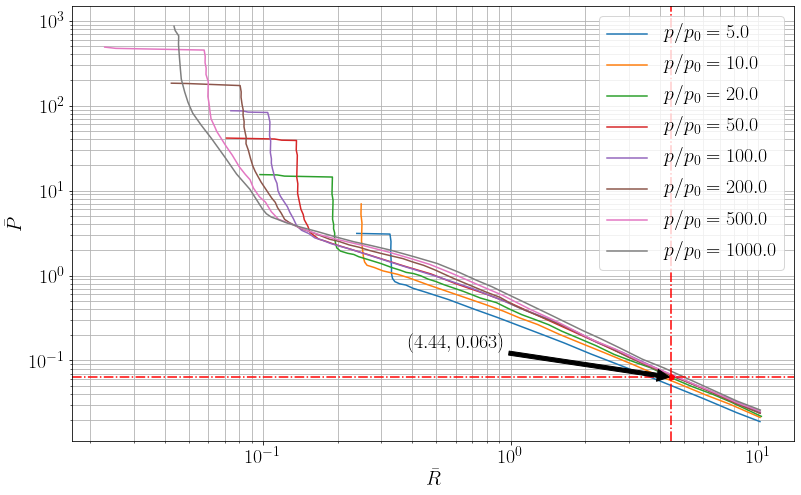

In [78]:
# Get an empty figure
fig1 = plt.figure(figsize = [w,h])

# Get the axes instance at 1st location in 1x1 grid
ax = fig1.add_subplot(1,1,1)

# Generate the plot
grpd = df_pr.groupby('w').apply(lambda x: x.sort_values('z')) # Group by 'w' then sort by 'z'
for name in grpd['z'].unique(): # Iterate through grouped values of z and plot
    plt.loglog(df_pr[df_pr.z==name].R.values, df_pr[df_pr.z==name].P.values, label = name);
plt.plot(R_bar_p,prp,'rp');
plt.legend();
plt.axhline(y=prp, color='r', linestyle='-.')
plt.annotate(r'$\left(4.44,0.063\right)$',
            xy=(R_bar_p, prp), xycoords='data',
            xytext=(0.6, 0.25), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),
            horizontalalignment='right', verticalalignment='top')
plt.axvline(x=R_bar_p, color='r', linestyle='-.')

# Set labels for x and y axis
ax.set_xlabel(r'$\bar R$');
ax.set_ylabel(r'$\bar P$');
ax.grid(True, which='both')

# Display the figure
plt.show();

Overpressure (psig)   Injury                               
-------------------   ----------------------------  
14.5                  Threshold for fatality
16.0                  50% ear drum rupture
17.5                  10% probability for fatality  
20.5                  50% probability for fatality
25.5                  90% probability for fatality
29.0                  99% probability for fatality

Table: Overpressure vs. Human Injury Probability\cite{nfpa_921_2014} {#tbl:tbl_nfpa align=ll widths=[0.25,0.4]}

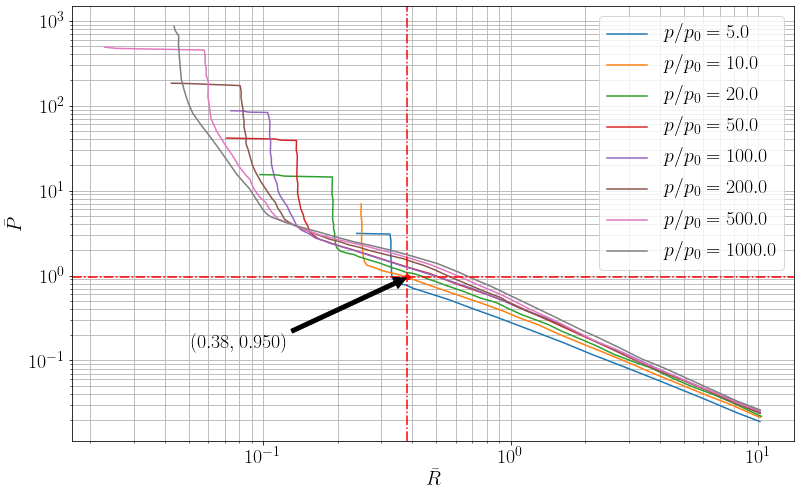

In [79]:
# Get an empty figure
fig1 = plt.figure(figsize = [w,h])

# Get the axes instance at 1st location in 1x1 grid
ax = fig1.add_subplot(1,1,1)

# Generate the plot
grpd = df_pr.groupby('w').apply(lambda x: x.sort_values('z')) # Group by 'w' then sort by 'z'
for name in grpd['z'].unique(): # Iterate through grouped values of z and plot
    plt.loglog(df_pr[df_pr.z==name].R.values, df_pr[df_pr.z==name].P.values, label = name);
plt.plot(R_bar_b,prb,'rp');
plt.legend();
plt.axhline(y=prb, color='r', linestyle='-.')
plt.axvline(x=R_bar_b, color='r', linestyle='-.')
plt.annotate(r'$\left(0.38,0.950\right)$',
            xy=(R_bar_b, prb), xycoords='data',
            xytext=(0.3, 0.25), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),
            horizontalalignment='right', verticalalignment='top')

# Set labels for x and y axis
ax.set_xlabel(r'$\bar R$');
ax.set_ylabel(r'$\bar P$');
ax.grid(True, which='both')

# Display the figure
plt.show();

In [80]:
ir5 = pd.read_csv('bleve_impulse_curves/ip1_p0_5.csv'); ir5['z'] = r'$p/p_0=5.0$'; ir5['w'] = 5.0
ir10 = pd.read_csv('bleve_impulse_curves/ip1_p0_10.csv'); ir10['z'] = r'$p/p_0=10.0$'; ir10['w'] = 10.0
ir20 = pd.read_csv('bleve_impulse_curves/ip1_p0_20.csv'); ir20['z'] = r'$p/p_0=20.0$'; ir20['w'] = 20.0
ir50 = pd.read_csv('bleve_impulse_curves/ip1_p0_50.csv'); ir50['z'] = r'$p/p_0=50.0$'; ir50['w'] = 50.0
ir100 = pd.read_csv('bleve_impulse_curves/ip1_p0_100.csv'); ir100['z'] = r'$p/p_0=100.0$'; ir100['w'] = 100.0
ir200 = pd.read_csv('bleve_impulse_curves/ip1_p0_200.csv'); ir200['z'] = r'$p/p_0=200.0$'; ir200['w'] = 200.0
ir500 = pd.read_csv('bleve_impulse_curves/ip1_p0_500.csv'); ir500['z'] = r'$p/p_0=500.0$'; ir500['w'] = 500.0
ir1000 = pd.read_csv('bleve_impulse_curves/ip1_p0_1000.csv'); ir1000['z'] = r'$p/p_0=1000.0$'; ir1000['w'] = 1000.0
frame = [ir5, ir10, ir20, ir50, ir100, ir200, ir500, ir1000]
df_ir = pd.concat(frame, sort=True)

In [81]:
#on a grid in [2, 18]x[0, 10] which was the axes of the
#original paper. The imaginary numbers 200j will break
#the grid into 200 equal spaces.

grid_x, grid_y = np.mgrid[0:10:200j, 0:1000:200j]

#we know the x,y,z values from the original plot image 

points = df_ir[['R','I']].values
values = df_ir['w'].values

points_df_ir = df_ir[['R','w']].values
values_df_ir = df_ir['I'].values

#The cubic method of griddata was used for interpolation.  Grid_x and Grid_y
#can be either a matrix of points or a single pair.
grid_z2_ir = griddata(points_df_ir, values_df_ir, (grid_x, grid_y), method='cubic')

irp = griddata(points_df_ir, values_df_ir, (R_bar_p, p_ratio_p), method='cubic')
print("The non-dimensional incident impulse for propane is %2.3f" % (irp))
irb = griddata(points_df_ir, values_df_ir, (R_bar_b, p_ratio_b), method='cubic')
print("The non-dimensional incident impulse for butane is %2.3f" % (irb))

The non-dimensional incident impulse for propane is 0.013
The non-dimensional incident impulse for butane is 0.107


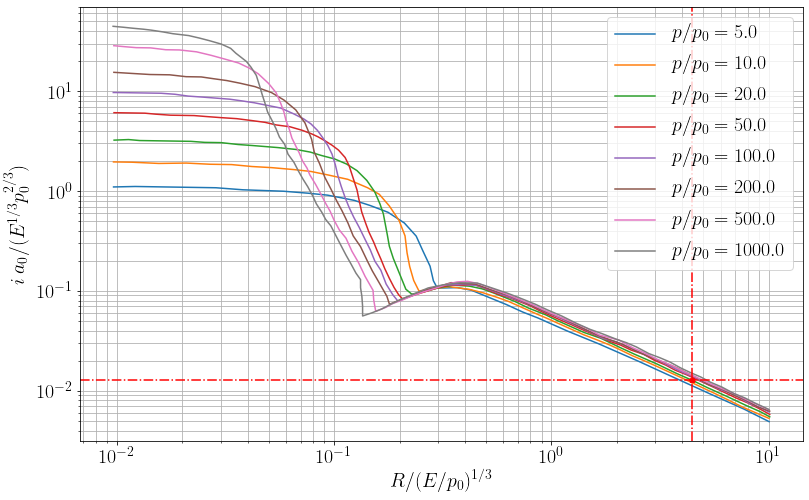

In [82]:
# Get an empty figure
fig2 = plt.figure(figsize = [w,h])

# Get the axes instance at 1st location in 1x1 grid
ax = fig2.add_subplot(1,1,1)

# Generate the plot
grpd = df_ir.groupby('w').apply(lambda x: x.sort_values('z')) # Group by 'w' then sort by 'z'
for name in grpd['z'].unique(): # Iterate through grouped values of z and plot
    plt.loglog(df_ir[df_ir.z==name].R.values, df_ir[df_ir.z==name].I.values, label = name);
plt.plot(R_bar_p,irp,'rp');
plt.legend();
plt.axhline(y=irp, color='r', linestyle='-.')
plt.axvline(x=R_bar_p, color='r', linestyle='-.')

# Set labels for x and y axis
ax.set_xlabel('$R/(E/p_0)^{1/3}$');
ax.set_ylabel('$i\:a_0/(E^{1/3}p_0^{2/3})$');
ax.grid(True, which='both')

# Display the figure
plt.show();

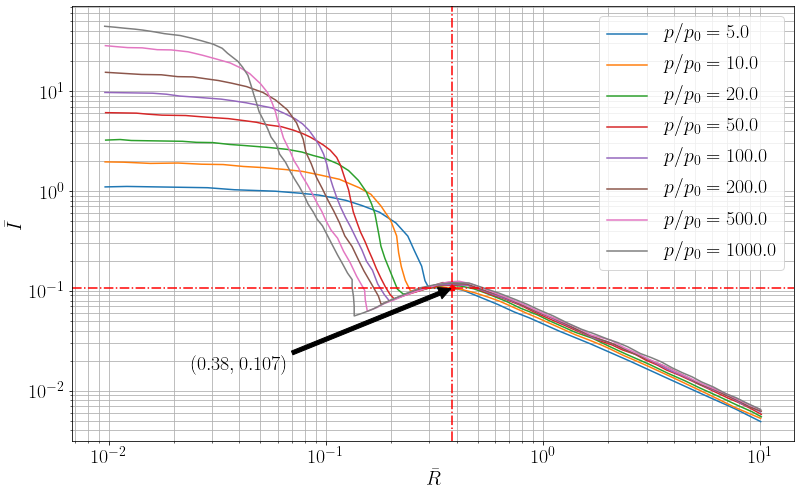

In [83]:
# Get an empty figure
fig2 = plt.figure(figsize = [w,h])

# Get the axes instance at 1st location in 1x1 grid
ax = fig2.add_subplot(1,1,1)

# Generate the plot
grpd = df_ir.groupby('w').apply(lambda x: x.sort_values('z')) # Group by 'w' then sort by 'z'
for name in grpd['z'].unique(): # Iterate through grouped values of z and plot
    plt.loglog(df_ir[df_ir.z==name].R.values, df_ir[df_ir.z==name].I.values, label = name);
plt.plot(R_bar_b,irb,'rp');
plt.legend();
plt.axhline(y=irb, color='r', linestyle='-.')
plt.axvline(x=R_bar_b, color='r', linestyle='-.')
plt.annotate(r'$\left(0.38,0.107\right)$',
            xy=(R_bar_b, irb), xycoords='data',
            xytext=(0.3, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),
            horizontalalignment='right', verticalalignment='top')

# Set labels for x and y axis
ax.set_xlabel(r'$\bar R$');
ax.set_ylabel(r'$\bar I$');
ax.grid(True, which='both')

# Display the figure
plt.show();

In [84]:
p_incidentp = prp*p_atm
print("The incident overpressure for propane is {:P.2f} ({:P.2f})".format(p_incidentp.to(u.kPa), p_incidentp.to(u.psi)))
p_incidentb = prb*p_atm
print("The incident overpressure for butane is {:P.2f} ({:P.2f})".format(p_incidentb.to(u.kPa), p_incidentb.to(u.psi)))

The incident overpressure for propane is 6.41 kilopascal (0.93 pound_force_per_square_inch)
The incident overpressure for butane is 96.26 kilopascal (13.96 pound_force_per_square_inch)


In [85]:
i_sp = (irp)*((p_atm.magnitude)**(2/3))*((E_extotp.to(u.J).magnitude)**(1/3))/a0.magnitude
print("The incident impulse for propane is %8.2f Pa-s (%3.2f psi-s)" % (i_sp, i_sp*0.000145038))
i_sb = (irb)*((p_atm.magnitude)**(2/3))*((E_extotb.to(u.J).magnitude)**(1/3))/a0.magnitude
print("The incident impulse for butane is %8.2f Pa-s (%3.2f psi-s)" % (i_sb, i_sb*0.000145038))

The incident impulse for propane is    85.65 Pa-s (0.01 psi-s)
The incident impulse for butane is   831.08 Pa-s (0.12 psi-s)


In [86]:
# Fragmentation Energy Propane
E_exfpf = 0.4*u_exfp*m_f1p # explosion energy of fluid on the ground (factor of 2) at state 1 (kJ)
E_exgpf = 0.4*u_exgp*m_g1p # explosion energy of gas on the ground at state 1 (kJ)
print("The fragmentation energy of the propane fluid at state 1 is {:P.2f}.".format(E_exfpf.to(u.MJ)))
print("The fragmentation energy of the propane vapor at state 1 is {:P.2f}.".format(E_exgpf.to(u.MJ)))
E_extotpf = E_exfpf+E_exgpf # total explosion energy on the ground at state 1
print("The total energy of the propane fragmentation is Ex_tot = {:P.2f}.".format(E_extotpf.to(u.MJ)))

The fragmentation energy of the propane fluid at state 1 is 221.20 megajoule.
The fragmentation energy of the propane vapor at state 1 is 10.98 megajoule.
The total energy of the propane fragmentation is Ex_tot = 232.19 megajoule.


In [87]:
# Fragmentation Energy Butane
E_exfbf = frag*u_exfb*m_f1b # explosion energy of fluid on the ground (factor of 2) at state 1 (kJ)
E_exgbf = frag*u_exgb*m_g1b # explosion energy of gas on the ground at state 1 (kJ)
print("The total energy of the butane fluid at state 1 is {:P.2f}.".format(u_exfb))
print("The fragmentation energy of the butane fluid at state 1 is {:P.2f}.".format(E_exfbf.to(u.MJ)))
print("The fragmentation energy of the butane vapor at state 1 is {:P.2f}.".format(E_exgbf.to(u.MJ)))
E_extotbf = E_exfbf+E_exgbf # total explosion energy on the ground at state 1
print("The total energy of the butane fragmentation is Ex_tot = {:P.2f}.".format(E_extotbf.to(u.MJ)))

The total energy of the butane fluid at state 1 is 57.58 kilojoule / kilogram.
The fragmentation energy of the butane fluid at state 1 is 819.24 megajoule.
The fragmentation energy of the butane vapor at state 1 is 143.97 megajoule.
The total energy of the butane fragmentation is Ex_tot = 963.22 megajoule.


# Debris from the BLEVE
The same explosion energy results developed in the overpressure and impulse calculations can be used for the fragmentation analysis.  However, the overpressure energy calculations applied a $grd=1.25$ ground reflection factor.  This factor is not applicable when determining the energy available for fragment throw calculations.  However, the $frag=0.4$ fragmentation factor should be applied.  Therefore, the available energy for fragmentation is,

$$E_{ex-f}=0.4(57.58kJ/kg)(35570.96kg)$$
$$E_{ex-f}=819.24MJ$$

and similarly for the saturated vapor,

$$E_{ex-g}=143.97MJ$$

Therefore the total energy for fragmentation is,

$$E_{tot} = 963.22MJ$$

## Initial Debris Speed
A conservative method for determining the initial speed of fragments is the empirical method proposed by Moore\cite{moore1967}.  The initial velocity is given by:

$$v_i = 1.0092\left(\frac{E_{tot}G}{M_C}\right)^{0.5}$$

where for a cylindrical vessel,

$$G = \frac{1}{1+M_G/2M_C}$$

and $M_G$ is the total gas mass, $E_{tot}$ is the energy, and $M_C$ is the mass of the vessel.  For our case we have,

$$v_i = 1.092\left(\frac{(963.22E6J)(0.60)}{35570.96kg}\right)^{0.5}$$

$$v_i = 318.85 mph\:(142.54 m/s)$$

In [88]:
e_bar_p = scaled_energy(E_extotpf.to(u.J), mass_p, gamma_p, RGC, T, mp)
print('e_bar_p = %2.2f'% e_bar_p.magnitude)

e_bar_p = 1.51


In [89]:
e_bar_b = scaled_energy(E_extotbf.to(u.J), mass.to(u.kg), gamma, RGC, T, mb)
print('e_bar_b = %2.2f'% e_bar_b.magnitude)

e_bar_b = 1.01


In [90]:
Cp = 0.8*(den_p)*V_1
i_vel_p, Gp = initial_V(E_extotpf.to(u.J).magnitude, mass_p.magnitude, Cp.magnitude)
i_vel_p, Gp

(179.67973795432076, 0.31751399253731344)

In [91]:
Cb = den_b*V_drum*Pct_l # density_butane*volumne_drum*percent_liquid_butane
i_vel_b, Gb = initial_V(E_extotbf.to(u.J).magnitude, mass.to(u.kg).magnitude, Cb.magnitude)
Gb
print('The initial velocity of the butane filled tank debris is estimated to be %2.2f mph (%2.2f m/s)' % (2.23694*i_vel_b, i_vel_b))

0.5990407665362687

The initial velocity of the butane filled tank debris is estimated to be 318.85 mph (142.54 m/s)


In [92]:
angle_d = np.arange(0,46, 1) #degrees
radians = lambda x: x*(m.pi/180)
angle_r = list(map(radians, angle_d))
result = []
for x in angle_r:
    result.append(initial_R(i_vel_b, x))

## Debris Throw Ranges
With the initial debris speed calculated and the distances to the three TFSD pieces known, we can calculate the required launch angle.  The initial trajectory angle $(a_i)$ can be calculated (neglecting lift and drag forces) using,

$$a_i = asin\left(\frac{Rg}{2v_i^2}\right)$$

where $R$ is the horizontal range and $g$ is the acceleration of gravity.  

For the initial velocity of $318.85mph\:(142.54m/s)$ the large-end-cap at a range of $2099.7ft\:(640m)$ would need a launch angle of $9.0^\circ$, the small-end-cap at a range of $1715.8ft\:(523m)$ would need a launch angle of $7.3^\circ$, and the center-section at a range of $816.9ft\:(249m)$ would need a launch of angle of $3.5^\circ$, see \cref{fig:fig_launch_angle}.  Therefore, the initial velocity predicted supports the throw ranges observed.  The maximum throw range possible (assuming no aerodynamic lift) occurs at a launch angle of $45^{\circ}$.  For this case, the maximum throw range would be $6794.9ft\:(2071.1m)$.

In [93]:
lec = 640 #m
sec = 523 #m
fil = 249 #m
mxm = 2071.107 #m

ang_lec = initial_angle(i_vel_b, lec)
ang_sec = initial_angle(i_vel_b, sec)
ang_fil = initial_angle(i_vel_b, fil)
ang_mxm = initial_angle(i_vel_b, mxm)

print('The large end cap travled %2.2f m with a launch angle of %2.2f degrees'% (lec, ang_lec))
print('The small end cap travled %2.2f m with a launch angle of %2.2f degrees'% (sec, ang_sec))
print('The fillet travled %2.2f m with a launch angle of %2.2f degrees'% (fil, ang_fil))
print('The maximum possible distance was %2.2f m with a launch angle of %2.2f degrees'% (mxm, ang_mxm))

The large end cap travled 640.00 m with a launch angle of 9.00 degrees
The small end cap travled 523.00 m with a launch angle of 7.31 degrees
The fillet travled 249.00 m with a launch angle of 3.45 degrees
The maximum possible distance was 2071.11 m with a launch angle of 44.99 degrees


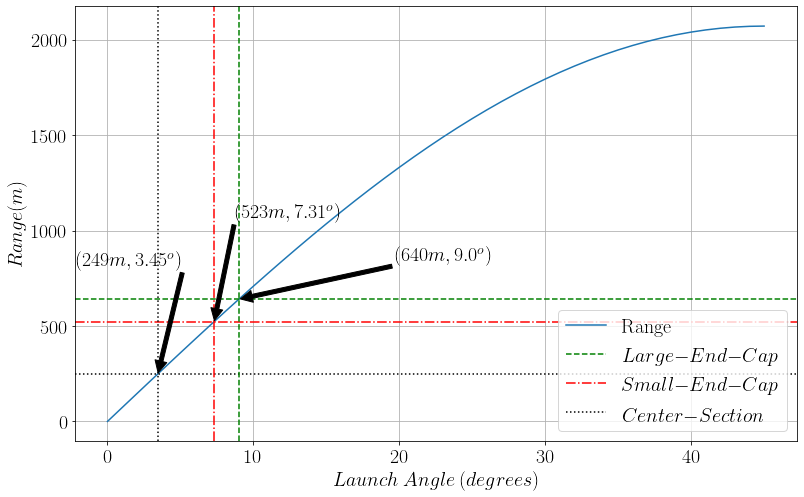

In [94]:
# Get an empty figure
fig3 = plt.figure(figsize = [w,h])
# Get the axes instance at 1st location in 1x1 grid
ax = fig3.add_subplot(1,1,1)
ax.plot(angle_d, result, label = 'Range');

ax.axhline(y=lec, color='g', linestyle='--', label=r'$Large{-}End{-}Cap$')
ax.axhline(y=sec, color='r', linestyle='-.', label=r'$Small{-}End{-}Cap$')
ax.axhline(y=fil, color='k', linestyle=':', label=r'$Center{-}Section$')
ax.axvline(x=ang_lec, color='g', linestyle='--')
ax.axvline(x=ang_sec, color='r', linestyle='-.')
ax.axvline(x=ang_fil, color='k', linestyle=':')
# Set labels for x and y axis
ax.set_xlabel(r'$Launch\:Angle\:(degrees)$');
ax.set_ylabel(r'$Range (m)$');
ax.grid(True, which='both')
ax.annotate(r'$\left(640m,9.0^o\right)$', xy=(initial_angle(i_vel_b,lec),lec),
            xycoords='data', xytext=(0.58, 0.45), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),horizontalalignment='right', 
            verticalalignment='top')
ax.annotate(r'$\left(523m,7.31^o\right)$', xy=(initial_angle(i_vel_b,sec),sec),
            xycoords='data', xytext=(0.37, 0.55), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),horizontalalignment='right', 
            verticalalignment='top')
ax.annotate(r'$\left(249m,3.45^o\right)$', xy=(initial_angle(i_vel_b,fil),fil),
            xycoords='data', xytext=(0.15, 0.44), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),horizontalalignment='right', 
            verticalalignment='top')
ax.legend(loc=4);

plt.show();

In [95]:
# Combine all calculations into a Pandas Dataframe
pd = nb_setup.setup_pandas(escape_latex=False)
df3 = pd.DataFrame(angle_d, columns = ['Angle (Degree)'])
df4 = pd.DataFrame(result, columns = ['Range (m)'])
df5 = pd.concat([df3, df4], axis=1)
df5.set_index('Angle (Degree)', inplace=True)
pd.options.display.float_format = '{:2.2f}'.format

# Thermal Radiation from the BLEVE
## Fireball Size and Duration
An estimate for the fireball diameter $D_c$ and duration $t_c$ generated from a BLEVE of $78420.54lb\:(35570.96kg)$ of liquid butane can be calculated using the equation,

$$D_c = 5.8m_f^{1/3}$$

where $m_f$ is the mass of fluid.  For this case,

$$D_c = 5.8(35570.96)^{1/3}$$
$$D_c = 625.81ft\:(190.75m)$$

see \cref{fig:fig_fireball_dia} for a scaled drawing showing the fireball size.  The fireball duration $t_c$ can be estimated from,

$$t_c = 0.45m_f^{1/3}$$
$$t_c = 0.45(35570.96)^{1/3}$$
$$t_c = 14.80s$$

Therefore, the fireball from the TFSD would have expanded to $625.81ft\:(190.75m)$ and then dissipated in $14.8s$.

![Diagram depicting the estimated fireball diameter, $625.8ft\:(190.7m)$,  from a butane BLEVE originating from the TFSD tank.  The TFSD tank and a 6ft human are shown for scale.](report_images/fig_fire_ball.png){#fig:fig_fireball_dia width=100% placement='H'}

In [96]:
d_c = 5.8*m_f1b.magnitude**(1/3) * u.m
print('The fireball diamter is estimated to be {:P.2f} ({:P.4f})'.format(d_c.to(u.ft), d_c))

The fireball diamter is estimated to be 625.81 foot (190.7479 meter)


In [97]:
t_c = 0.45*m_f1b.magnitude**(1/3) * u.s
print('The fireball duration was estimated to last {:P.2f}'.format(t_c))

The fireball duration was estimated to last 14.80 second


## Thermal Radiation
An estimate for the thermal (infrared) radiation from the BLEVE can be estimated for a standing (vertical) observer some distance from the fireball.  The thermal radiation can then be converted to thermal dose units $(TDU)$ to determine the range where the thresholds for pain and 1st, 2nd, and 3rd degree burns would be observed.  The critical TDUs are summarized in \cref{tbl:tbl_TDU}.

Harm Caused                    Mean TDU $((kW/m^2)^{4/3}s)$
--------------------------     ----------------------------
Pain                           92
Threshold 1st Degree Burns     105
Threshold 2nd Degree Burns     290
Threshold 3rd Degree Burns     1000

Table: Burn Injury vs. Thermal Dose Relationship \cite{OSullivan2004} {#tbl:tbl_TDU align=lr widths=[0.35,0.25]}

To estimate the harm to an observer, the relationship between the emitter (fireball) and the observer (person) must be determined.  This relationship is called the view factor and for a spherical emitter and vertical surface can be found from,

$$F_v = \frac{x(D/2)^2}{(x^2+H^2)^{3/2}}$$

where $D$ is the diameter and $H$ is the height to the center of the fireball.  The fireball is assumed to be spherical with a height of $H = 343.9ft\:(104.8m)$ and a diameter $D = 312.9ft\:(95.4m)$.  The range $x$ will be evaluated over a series of distances to determine where critical points of human injury (pain and burns) are predicted to occur, see \cref{fig:fig_fireball_thermal}.

![Diagram depicting the parameters for calculating the view factor used to estimate the thermal radiation received by the receptor.  The receptor (human) is not shown to scale.](report_images/fig_radiation_estimate.png){#fig:fig_fireball_thermal width=100% placement='H'}

Assuming a surface-emissive power of $E = 350kW/m^2$ for the surface of the fireball and an atmospheric transmissivity of $\tau_a = 1$ it is possible to estimate the radiation received by the observer using,

$$q = EF_v\tau_a$$

## Thermal Dose Units

Finally, the thermal dose units $(TDU)$ received by the observer can be estimated by assuming they are exposed to the full fireball duration of $t_c = 14.80s$ using\cite{OSullivan2004},

$$TDU = q^{4/3}t_c$$

If the range to the observer is varied from $984.3ft\:(300m)$ to $3280.8ft\:(1000m)$ we can calculate the view factor $(F_v)$, radiation $(q)$, and thermal dose units $(TDU)$ for the observer.  Refer to \cref{tbl:TDU} for a summary of the calculations.  We can then compare the critical $TDU$ in \cref{tbl:tbl_TDU} to the calculated $TDUs$ at various ranges from the fireball, see \cref{fig:fig_tdu}.  For the observer to be exposed to 3rd degree burns they would need to be inside of $1312.3ft\:(400m)$, 2nd degree burns inside of $1968.5ft\:(600m)$, and 1st degree burns inside of $2952.76ft\:(900m)$.

In [98]:
D = d_c.magnitude
X = np.arange(300, 1050, 50)
H = d_c/2 + 31 * u.ft
H = H.magnitude
F_v = f_v(X,D,H)

e = 350
tau = 1
Q = q(e,F_v,tau)

TDU = tdu(Q,t_c.magnitude)

In [99]:
# Combine all calculations into a Pandas Dataframe
pd = nb_setup.setup_pandas(escape_latex=False)
df3 = pd.DataFrame(X, columns = ['Ground Distance (m)'])
df4 = pd.DataFrame(F_v, columns = ['View Factor'])
df5 = pd.DataFrame(Q, columns = ['Solid Flame Raditation ($kW/m^2$)'])
df6 = pd.DataFrame(TDU, columns = ['Thermal Dose Units ($(kW/m^2)^{4/3}s$)'])
df7 = pd.concat([df3, df4, df5, df6], axis=1)
df7.set_index('Ground Distance (m)', inplace=True)
pd.options.display.float_format = '{:2.4f}'.format
df7

,View Factor,Solid Flame Raditation ($kW/m^2$),Thermal Dose Units ($(kW/m^2)^{4/3}s$)
Ground Distance (m),,,
300,0.0850,29.7609,1364.9134
350,0.0653,22.8472,959.4496
400,0.0515,18.0111,698.7112
450,0.0415,14.5238,524.4272
500,0.0341,11.9390,403.8322
550,0.0285,9.9761,317.8266
600,0.0242,8.4536,254.8573
650,0.0207,7.2506,207.6883
700,0.0180,6.2847,171.6423


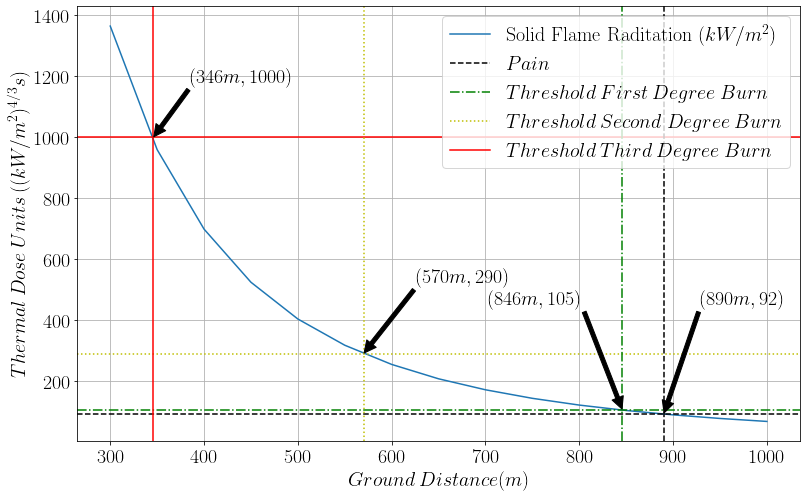

In [100]:
x = df7.index.values
y = df7['Thermal Dose Units ($(kW/m^2)^{4/3}s$)'].values



# Get an empty figure
fig4 = plt.figure(figsize = [w,h])
# Get the axes instance at 1st location in 1x1 grid
ax = fig4.add_subplot(1,1,1)
ax.plot(x, y, label = 'Solid Flame Raditation ($kW/m^2$)');

ax.axhline(y=92, color='k', linestyle='--', label=r'$Pain$')
ax.axhline(y=105, color='g', linestyle='-.', label=r'$Threshold\:First\:Degree\:Burn$')
ax.axhline(y=290, color='y', linestyle=':', label=r'$Threshold\:Second\:Degree\:Burn$')
ax.axhline(y=1000, color='r', linestyle='-', label=r'$Threshold\:Third\:Degree\:Burn$')

ax.axvline(x=890, color='k', linestyle='--')
ax.axvline(x=846, color='g', linestyle='-.')
ax.axvline(x=570, color='y', linestyle=':')
ax.axvline(x=346, color='r', linestyle='-')

# Set labels for x and y axis
ax.set_xlabel(r'$Ground\:Distance (m)$');
ax.set_ylabel(r'$Thermal\:Dose\:Units\:((kW/m^2)^{4/3}s)$');
ax.grid(True, which='both')
ax.annotate(r'$\left(890m,92\right)$', xy=(890,92),
            xycoords='data', xytext=(0.98, 0.35), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),horizontalalignment='right', 
            verticalalignment='top')
ax.annotate(r'$\left(846m,105\right)$', xy=(846,105),
            xycoords='data', xytext=(0.7, 0.35), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),horizontalalignment='right', 
            verticalalignment='top')
ax.annotate(r'$\left(570m,290\right)$', xy=(570,290),
            xycoords='data', xytext=(0.6, 0.4), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),horizontalalignment='right', 
            verticalalignment='top')
ax.annotate(r'$\left(346m,1000\right)$', xy=(346,1000),
            xycoords='data', xytext=(0.3, 0.86), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01),horizontalalignment='right', 
            verticalalignment='top')
ax.legend(loc=1);
plt.show();

# Conclusion
The BLEVE analysis indicates the following:

* The calculated overpressure $28.66psia\:(197603.74Pa)$ at $32.8ft\:(10m)$ would be lethal to a human in the open.  The threshold for fatality would be approximately than $869.4ft\:(265m)$
* The large and small-end-caps and the center-section debris had sufficient initial velocity $318.85mph\:(142.54m/s)$ to be thrown the distances observed.  The maximum throw distance possible would be $6794.9ft\:(2071.1m)$.
* The thermal effects would produce 2nd degree burns at $1870ft\:(570m)$ and 3rd degree burns at $1135ft\:(346m)$.

This BLEVE analysis is based on safety-engineering models therefore, estimates for the consequences are considered conservative.  This type of analysis is used during the design phase of a plant to identify process engineering hazards for employees and the public.